In [ ]:
# Import modules
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import stats
from scipy.signal import argrelextrema
# Our own modules
from get_waterlevel import download_waterlevel
from multiple_regression_tidal_constituents import multiple_regression


In [2]:
# Read the information about all water level stations from file
df_stations_info = pd.read_csv('tide_stations_loc.csv', index_col=1)

# Define the stations we are interested in
stations = ['HFT', 'BOO', 'MAY', 'TRG']

# Download water level data for these station from the Norwegian Mapping Authority's API
start_date = '2010-01-01'    # First day for which to download water level data.
end_date = '2020-12-31'      # Last day for which to download water level data.
for station in stations:
    lat = df_stations_info.loc[station]['latitude']
    lon = df_stations_info.loc[station]['longitude']
    #download_waterlevel(start_date, end_date, station_code, lat, lon)    # Commented out now so it doesn't actually download the data


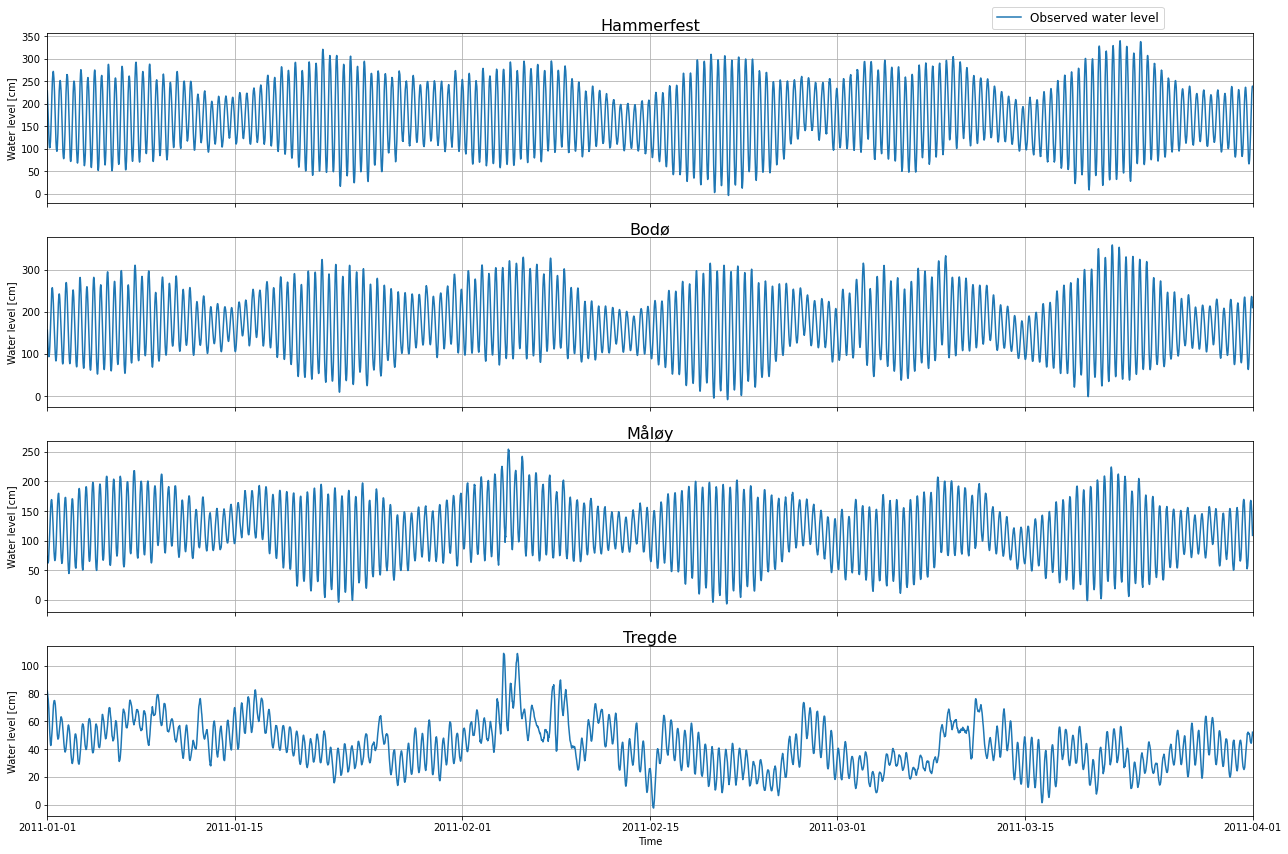

In [17]:
#-----------------------------------------------------------------------------#
# Look at and describe the data
#-----------------------------------------------------------------------------#

# Define some parameters
year = '2011'       # Limit the analysis to one year for now

# Initialize dictionaries to hold data
df_stations = {}    # Water level data at the stations

# Read in the water level data
for station in stations:
    #print(f'Performing multiple regression for station {station}')
    df_stations[station] = pd.read_csv(f'{station}_waterlevel.csv', index_col=0, parse_dates=True)
    # Remove the mean waterlevel from the time series
    df_stations[station]['level_demean'] = df_stations[station]['Level'].copy() - df_stations[station]['Level'].mean()
    # Calculate for each observation the number of hours elapsed since the first observation
    df_stations[station]['tk'] = (df_stations[station].index - df_stations[station].index[0]).total_seconds()/(60*60)
    # Select the year we want to analyse
    df_stations[station] = df_stations[station].loc[year]

# Plot the data
fig, axs = plt.subplots(4, 1, sharex='all', figsize=(21.6,14.4))
for i in range(len(stations)):
    # Add a new subplot for this station
    station = stations[i]
    axs[i].plot(df_stations[station]['Level'].loc['2011-01':'2011-03'], label='Observed water level')
    #axs[i].plot(df_stations[station]['regression'].loc['2011-01':'2011-03'], label='Modelled water level')
    axs[i].set_ylabel('Water level [cm]')
    axs[i].text(0.5, 1, df_stations_info.loc[station]['name'], verticalalignment='bottom',
            horizontalalignment='center', transform=axs[i].transAxes, fontsize=16)
    axs[i].grid(True)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.855, 1.19), ncol=2, fontsize=12)
axs[-1].set_xlabel('Time')
axs[-1].set_xlim(pd.Timestamp('2011-01-01'), pd.Timestamp('2011-04-01'));


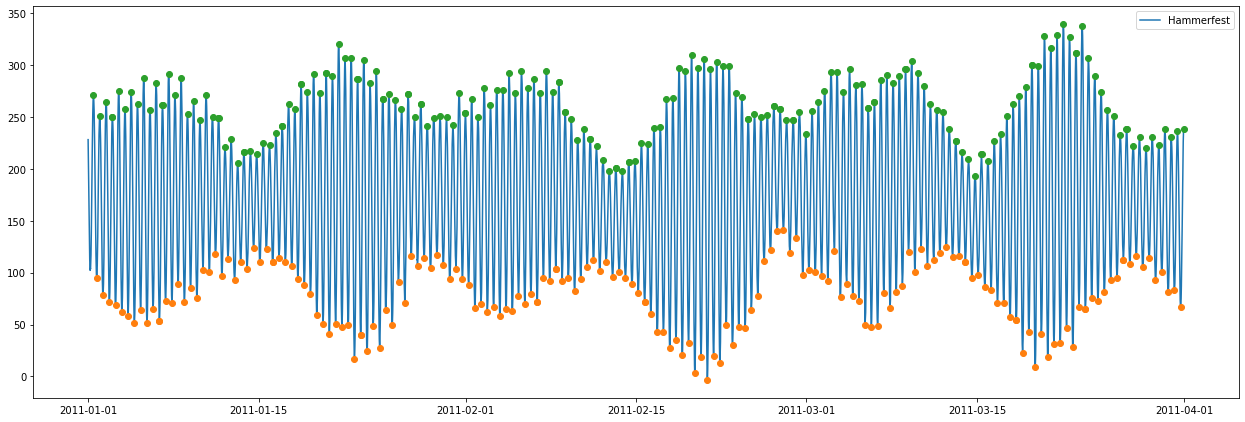

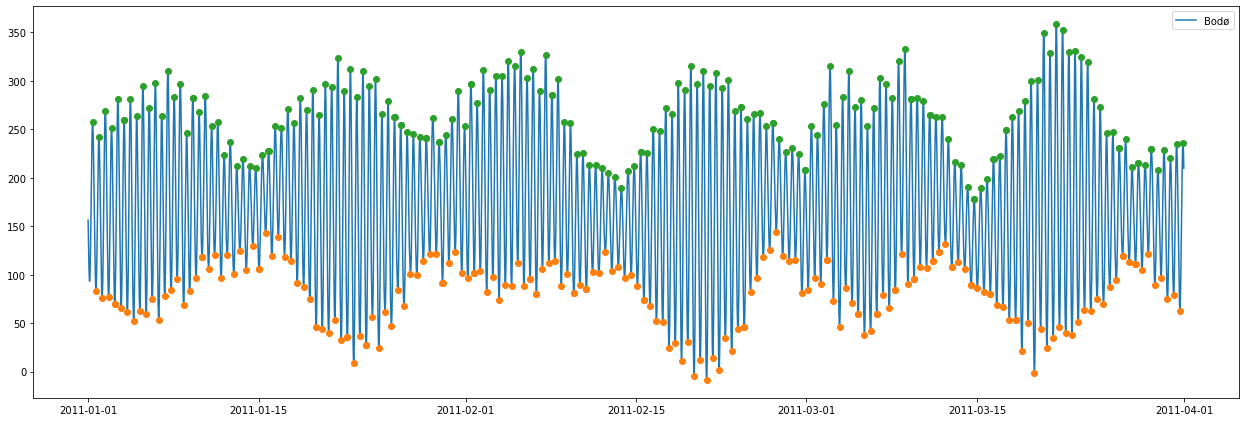

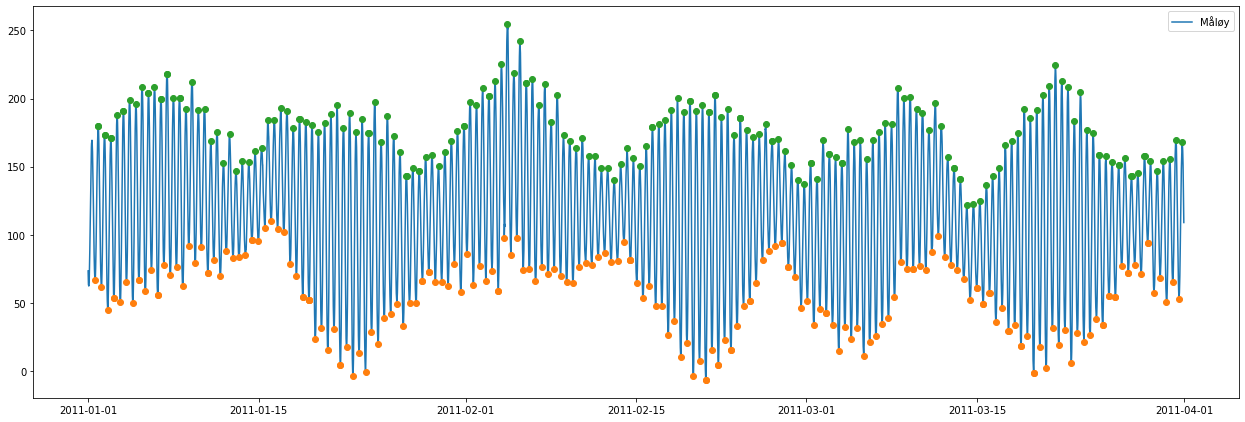

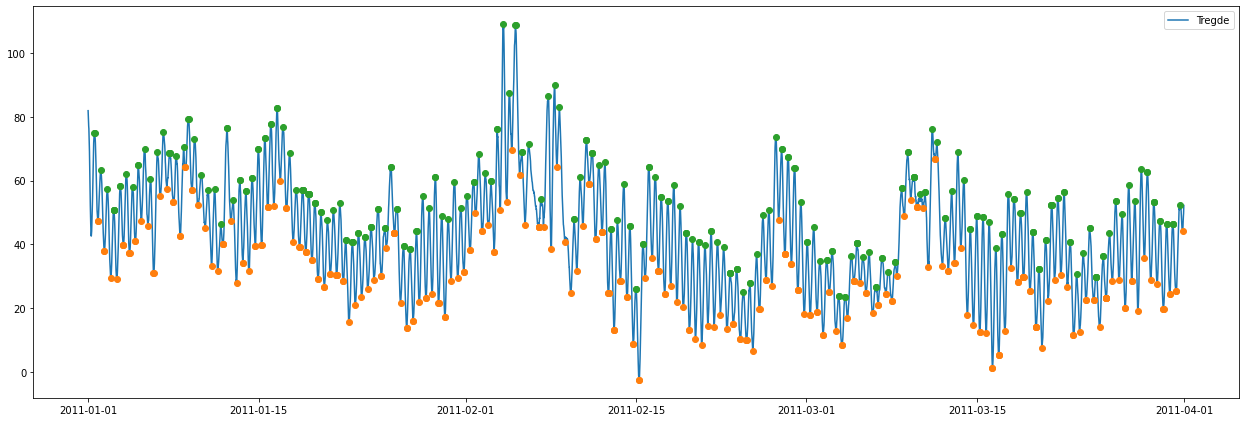

Station: Hammerfest, Mean tidal range: 184.22 cm.
Station: Bodø, Mean tidal range: 182.75 cm.
Station: Måløy, Mean tidal range: 121.76 cm.
Station: Tregde, Mean tidal range: 21.70 cm.


In [63]:

#--- Calculate the tidal range, i.e. average difference between water level at high and low tide
# Use Scipy to identify the local maximums and minimums. Do not include the first and last min and max points, 
# since these points will be identified as local extrema, without necessarily corresponding to high or low tide

for station in stations:
    df_stations[station]['min'] = df_stations[station].iloc[argrelextrema(
        df_stations[station]['Level'].values, np.less_equal, order=24
        )[0]]['Level'][1:-1]
    df_stations[station]['max'] = df_stations[station].iloc[argrelextrema(
        df_stations[station]['Level'].values, np.greater_equal, order=24
        )[0]]['Level'][1:-1]

plot_time1 = '2011-01-01'
plot_time2 = '2011-03-31'
plotting = True

if plotting:
    for station in stations:
        plt.figure(figsize=(21.6,7.2))
        plt.plot(df_stations[station]['Level'].loc[plot_time1:plot_time2], label=df_stations_info.loc[station]["name"])
        plt.plot(df_stations[station]['min'].loc[plot_time1:plot_time2][~np.isnan(df_stations[station]['min'].loc[plot_time1:plot_time2])], marker='o', ls='')
        plt.plot(df_stations[station]['max'].loc[plot_time1:plot_time2][~np.isnan(df_stations[station]['max'].loc[plot_time1:plot_time2])], marker='o', ls='')
        plt.legend()
        plt.show()

# Is max.mean() - min.mean() the tidal range we're looking for??
tidal_range = {}
for station in stations:
    tidal_range[station] = df_stations[station]['max'].mean() - df_stations[station]['min'].mean()
    print(f'Station: {df_stations_info.loc[station]["name"]}, Mean tidal range: {tidal_range[station]:.2f} cm.')


In [4]:
#-----------------------------------------------------------------------------#
# Perform multiple regression to find the most important tidal constituents for each station
#-----------------------------------------------------------------------------#

# Define some parameters
alpha = 0.05        # Significance level

# Initialize a dictionarie to hold the results
results = {}        # Results of the multiple regression

#--- Prepare for the regression
# Read tidal constituents from file
#tidal_constituents = pd.read_csv('tidal_harmonics_2.txt', sep=' ', usecols=['NAME', 'FREQUENCY'], index_col='NAME')
# Calculate the angular velocity of the tidal constituents from the frequency
#tidal_constituents['Angular Speed (degrees/hour)'] = 360 * tidal_constituents['FREQUENCY']

# Read tidal constituents from file
tidal_constituents = pd.read_excel('tidal_harmonics.xlsx', index_col=0)

# Perform the regression
for station in stations:
    print(f'Performing multiple regression for station {station}')
    results[station] = multiple_regression(df_stations[station], tidal_constituents, alpha)


Performing multiple regression for station HFT
Regression nr. 1, most important constituent: M2
Regression nr. 2, most important constituent: S2
Regression nr. 3, most important constituent: N2
Regression nr. 4, most important constituent: Sa
Regression nr. 5, most important constituent: K1
Regression nr. 6, most important constituent: K2
Regression nr. 7, most important constituent: Ssa
Regression nr. 8, most important constituent: Mm
Regression nr. 9, most important constituent: V2
Regression nr. 10, most important constituent: O1
Regression nr. 11, most important constituent: _2N2
Regression nr. 12, most important constituent: MSf
Regression nr. 13, most important constituent: MU2
Adding the tidal constituent MU2 does not significantly improve the regression. The regression is ended here.
Performing multiple regression for station BOO
Regression nr. 1, most important constituent: M2
Regression nr. 2, most important constituent: S2
Regression nr. 3, most important constituent: Sa
Reg

In [5]:
# Print some results of the regressions
for station in stations:
    n = len(results[station]["list_of_most_important_constituents"])    # Number of significant tidal constituents

    print(f'Station {station}:')
    print(f' Number of significant tidal constituents: {n}')
    print(f' Significant tidal constituents: {results[station]["list_of_most_important_constituents"]}')
    print(f' R^2 for the full regression: {results[station][f"regression_{n}"]["R2"]:.3f}')
    print()

Station HFT:
 Number of significant tidal constituents: 12
 Significant tidal constituents: ['M2', 'S2', 'N2', 'Sa', 'K1', 'K2', 'Ssa', 'Mm', 'V2', 'O1', '_2N2', 'MSf']
 R^2 for the full regression: 0.959

Station BOO:
 Number of significant tidal constituents: 14
 Significant tidal constituents: ['M2', 'S2', 'Sa', 'N2', 'K1', 'Ssa', 'K2', 'Mm', 'V2', 'O1', 'P1', '_2N2', 'M4', 'Mf']
 R^2 for the full regression: 0.949

Station MAY:
 Number of significant tidal constituents: 10
 Significant tidal constituents: ['M2', 'S2', 'Sa', 'N2', 'Ssa', 'K2', 'Mm', 'O1', 'K1', 'Mf']
 R^2 for the full regression: 0.914

Station TRG:
 Number of significant tidal constituents: 5
 Significant tidal constituents: ['Sa', 'M2', 'Mm', 'Ssa', 'Mf']
 R^2 for the full regression: 0.472



In [6]:
# Calculate the full regression time series for each station
for station in stations:
    n = len(results[station]["list_of_most_important_constituents"])    # Number of significant tidal constituents
    # Initialize the regression with the intercept
    regression = results[station][f'regression_{n}']['params']['Intercept']
    # Loop over the constituents used in the regression for this station and add their contribution to the regression
    for constituent in results[station]['list_of_most_important_constituents']:
        regression += (
            results[station][f'regression_{n}']['params'][f'{constituent}_cos']
            * np.cos(np.deg2rad(tidal_constituents.loc[constituent]['Angular Speed (degrees/hour)']*df_stations[station]['tk']))
            + results[station][f'regression_{n}']['params'][f'{constituent}_sin']
            * np.sin(np.deg2rad(tidal_constituents.loc[constituent]['Angular Speed (degrees/hour)']*df_stations[station]['tk']))
        )
    # The regressions were done after removing the mean waterlevel from the time series. Add it again now.
    df_stations[station]['regression'] = regression + df_stations[station]['Level'].mean()
    
    # The above code calculates the regression from the rewritten expression, where A*cos(ai*t - phi) is spit into a cosine and a sine
    # We should also calculate the regression based on the original expression, with amplitude and phase
    # Initialize the regression2 with the intercept
    regression2 = results[station][f'regression_{n}']['params']['Intercept']
    # Loop over the constituents used in the regression for this station and add their contribution to the regression
    for constituent in results[station]['list_of_most_important_constituents']:
        amplitude = np.sqrt(
            results[station][f'regression_{n}']['params'][f'{constituent}_cos']**2
            + results[station][f'regression_{n}']['params'][f'{constituent}_sin']**2
        )
        phase = np.arctan2(
            results[station][f'regression_{n}']['params'][f'{constituent}_sin'],
            results[station][f'regression_{n}']['params'][f'{constituent}_cos']
        )
        # numpy arctan2 gives an angle in the range [-pi, pi], convert it to [0, 2pi]
        if phase < 0:
            phase += 2*np.pi
        regression2 += amplitude*np.cos(np.deg2rad(tidal_constituents.loc[constituent]['Angular Speed (degrees/hour)']*df_stations[station]['tk']) - phase)
    # The regressions were done after removing the mean waterlevel from the time series. Add it again now.
    df_stations[station]['regression2'] = regression2 + df_stations[station]['Level'].mean()


In [7]:
# Are the two regressions equal???
#for i in range(int(len(df_stations['HRO']['regression'].index))):
#    if round(df_stations['HRO']['regression'][i], 4) == round(df_stations['HRO']['regression2'][i], 4):
#        continue
#    else:
#        print('Not equal')

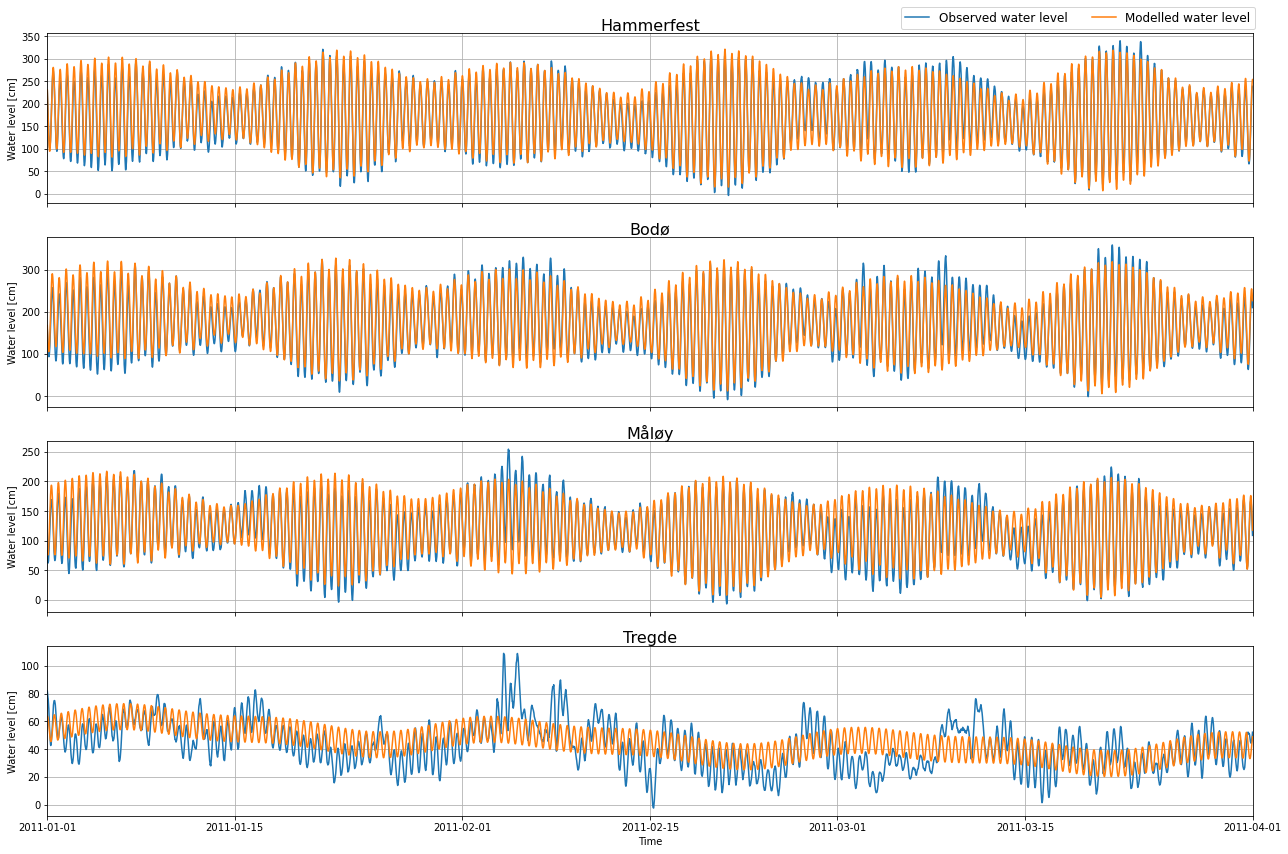

In [8]:
###
# Plot the regression and observations
###

fig, axs = plt.subplots(4, 1, sharex='all', figsize=(21.6,14.4))
for i in range(len(stations)):
    # Add a new subplot for this station
    station = stations[i]
    axs[i].plot(df_stations[station]['Level'].loc['2011-01':'2011-03'], label='Observed water level')
    axs[i].plot(df_stations[station]['regression'].loc['2011-01':'2011-03'], label='Modelled water level')
    axs[i].set_ylabel('Water level [cm]')
    axs[i].text(0.5, 1, df_stations_info.loc[station]['name'], verticalalignment='bottom',
            horizontalalignment='center', transform=axs[i].transAxes, fontsize=16)
    axs[i].grid(True)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.855, 1.19), ncol=2, fontsize=12)
axs[-1].set_xlabel('Time')
axs[-1].set_xlim(pd.Timestamp('2011-01-01'), pd.Timestamp('2011-04-01'));


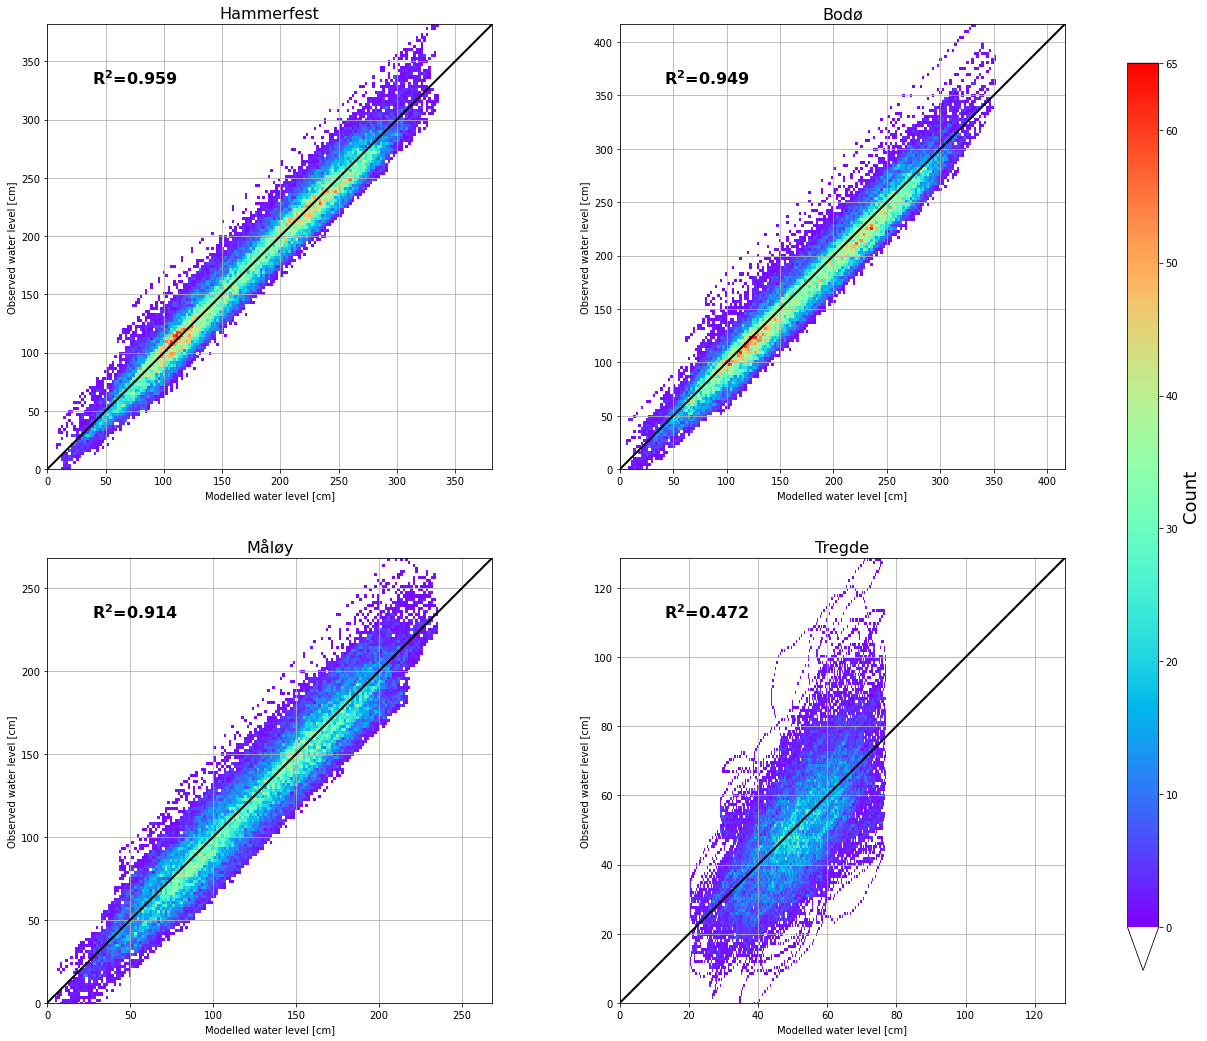

In [9]:
###
# Make scatterplots
###
# Initialize dictionaries to hold the data we need for the scatterplots
x = {}       # Modelled water level
y = {}       # Observed water level
H = {}       # Bi-dimensional histogram of observed and modelled water level
xedges = {}  # Bin edges along the x dimension
yedges = {}  # Bin edges along the y dimension

# Loop over the stations to count model-obs pairs in a set of bins
for station in stations:
    # Remove nan values
    x[station] = df_stations[station]['regression'][~np.isnan(df_stations[station]['regression'])].values
    y[station] = df_stations[station]['Level'][~np.isnan(df_stations[station]['Level'])].values
    x[station] = x[station][~np.isnan(y[station])]
    y[station] = y[station][~np.isnan(x[station])]
    # Compute the number of model-obs pairs in water level bins
    H[station], xedges[station], yedges[station] = np.histogram2d(x[station], y[station], bins=150)
    # According to the Numpy documentation H does not follow the Cartesian convention where x values are on the abscissa and y values on the ordinate axis.
    # Therefore, we transpose H for plotting
    H[station] = H[station].T
    # Set the bins with no pairs to nan, so they will be white in the plot
    H[station][H[station]==0] = np.nan

# Adjust the color map for the plotting so that bins with no model-obs pairs will be white
palette = plt.get_cmap('rainbow').copy()
palette.set_bad("white")
palette.set_under("white", 1.0)
# Find the maximum number of model-obs pair in any bin, so the color scale will the same in all the scatterplots
H_max = np.max([H[station][~np.isnan(H[station])].max() for station in stations])

# Plot
fig = plt.figure(figsize=(21.6,18))
for i in range(len(stations)):
    # Add a new subplot for the station
    station = stations[i]
    ax = plt.subplot(2,2, i + 1, aspect='equal')
    im = ax.pcolormesh(xedges[station], yedges[station], H[station], vmin=0, vmax=H_max, cmap=palette)
    # Find the maximum water level value observed or modelled to use as axis limit
    axis_max = np.max([x[station].max(), y[station].max()])
    # Plot a straight line for the perfect fit
    line = np.linspace(0, axis_max, 1000)
    ax.plot(line, line, color='k', lw=2.0)
    # Format the plot by adding title, axis labels etc.
    ax.set_xlim(0, axis_max)
    ax.set_ylim(0, axis_max)
    ax.set_title(df_stations_info.loc[station]['name'], fontsize=16)
    ax.set_xlabel('Modelled water level [cm]')
    ax.set_ylabel('Observed water level [cm]')
    ax.grid()
    # Write the R^2 value for the regression
    n = len(results[station]["list_of_most_important_constituents"])
    R2 = results[station][f'regression_{n}']['R2']
    ax.text(0.1, 0.9, s=fr'$\mathbf{{R^{2}}}$={R2:.3f}', verticalalignment='top', 
             horizontalalignment='left', transform=ax.transAxes, fontsize=16, fontweight='bold')

# Plot the colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.02, 0.7])
cb = plt.colorbar(im, cax=cbar_ax, extend='min', ticks=[0, 10, 20, 30, 40, 50, 60, H_max]);
cb.set_label(label='Count', size=18)


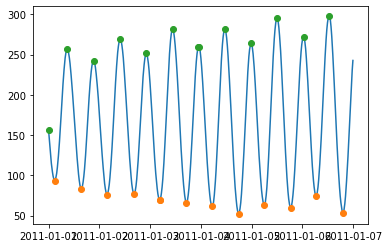

In [10]:
#-----------------------------------------------------------------------------#
# Compute time shift, i.e. lag between high tides (and low tide) between the different stations
#    NOTE: Helgeroa/Tregde is in the North Sea, so a different "tidal domain" than the other stations, 
#          and it will not be included in this analysis
#-----------------------------------------------------------------------------#

# Use Scipy to identify the local maximums and minimums

#df_stations['BOO']['min'] = df_stations['BOO']['Level'][(df_stations['BOO']['Level'].shift(1) > df_stations['BOO']['Level']) & (df_stations['BOO']['Level'].shift(-1) > df_stations['BOO']['Level'])]
for station in ['HFT', 'BOO', 'MAY']:
    df_stations[station]['min'] = df_stations[station].iloc[argrelextrema(
        df_stations[station]['Level'].values, np.less_equal, order=5
        )[0]]['Level']
    df_stations[station]['max'] = df_stations[station].iloc[argrelextrema(
        df_stations[station]['Level'].values, np.greater_equal, order=5
        )[0]]['Level']

plot_time1 = '2011-01-01'
plot_time2 = '2011-01-06'

plt.plot(df_stations['BOO']['Level'].loc[plot_time1:plot_time2])
plt.plot(df_stations['BOO']['min'].loc[plot_time1:plot_time2][~np.isnan(df_stations['BOO']['min'].loc[plot_time1:plot_time2])], marker='o', ls='')
plt.plot(df_stations['BOO']['max'].loc[plot_time1:plot_time2][~np.isnan(df_stations['BOO']['max'].loc[plot_time1:plot_time2])], marker='o', ls='')


